## Bernoulli AR Run-time and MSE Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first simulation in the paper. 

In this example simulate three fixed effects $\beta \sim$ rand(Uniform(-2, 2), p) where p = 3 fixed effects.

In this example we have bernoulli base distribution with Logit Link function and covariance matrix $\Gamma$ structured under AR covariance with $\rho = 0.5, \sigma^2 = 0.5$

We run each scenario 100 times.

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept

# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-2, 2), p)
σ2true = [0.5]
ρtrue = [0.5]
θtrue = [σ2true; ρtrue]

# generate data
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
σ2MseResult = vec(readdlm("mse_sigma_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
ρMseResult = vec(readdlm("mse_rho_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
fittimes = vec(readdlm("fittimes_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
  0.083686317
  0.112278678
  0.102913605
  0.244858795
  0.133811049
  0.068555934
  0.072827674
  0.092548517
  0.052242746
  0.203106294
  0.028264428
  0.084288541
  0.05823075
  ⋮
  6.074480134
  8.210310409
  5.284680403
  6.957037464
  6.390149053
  6.73806364
 10.432193891
  8.567766963
  8.272479322
  7.659158567
  5.256047029
  7.425565744

In [5]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, σ2mse = σ2MseResult, ρmse = ρMseResult,
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[5]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0893198,0.00396545,200,0.0853544,0.0932853,0.000446599
2,100,5,0.102854,0.00448738,500,0.0983665,0.107341,0.000205708
3,100,10,0.221335,0.0188127,1000,0.202522,0.240147,0.000221335
4,100,15,0.292488,0.0216948,1500,0.270793,0.314183,0.000194992
5,100,20,0.371087,0.0239181,2000,0.347169,0.395005,0.000185543
6,100,25,0.468766,0.0258027,2500,0.442963,0.494569,0.000187506
7,1000,2,0.133152,0.00443218,2000,0.12872,0.137584,6.65761e-5
8,1000,5,0.193668,0.00657113,5000,0.187097,0.20024,3.87337e-5
9,1000,10,0.266626,0.00613594,10000,0.26049,0.272762,2.66626e-5


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


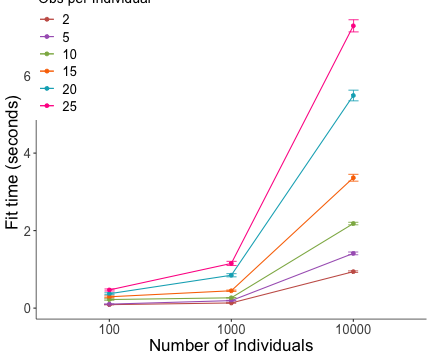

RObject{VecSxp}


In [6]:
########### plot the runtimes
using RCall
@rput timedf

R"""
library(ggplot2)
timedf$obssize = factor(timedf$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf$samplesize = factor(timedf$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")
"""

In [7]:
R"""
ggsave('fittime_nobs_bernoulli_AR_uni2_rho_sigma2_0.5.png', fittime_1, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nobs_bernoulli_AR_uni2_rho_sigma2_0.5.png"


In [8]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βρσ2coverage = readdlm("beta_rho_sigma_coverage_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ',')

m = 2

covdf = DataFrame(Matrix(transpose(βρσ2coverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["σ2"];  ["ρ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["σ2"]; ["ρ"]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,σ2
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.49, 0.0502418)","(0.19, 0.0394277)","(0.29, 0.0456048)","(0.75, 0.0435194)"
2,N: 100 ni: 5,"(0.54, 0.0500908)","(0.26, 0.0440844)","(0.52, 0.0502117)","(0.68, 0.0468826)"
3,N: 100 ni: 10,"(0.57, 0.049757)","(0.42, 0.0496045)","(0.69, 0.0464823)","(0.82, 0.0386123)"
4,N: 100 ni: 15,"(0.65, 0.0479372)","(0.26, 0.0440844)","(0.76, 0.0429235)","(0.74, 0.0440844)"
5,N: 100 ni: 20,"(0.6, 0.0492366)","(0.42, 0.0496045)","(0.83, 0.0377525)","(0.72, 0.0451261)"
6,N: 100 ni: 25,"(0.55, 0.05)","(0.34, 0.0476095)","(0.76, 0.0429235)","(0.81, 0.0394277)"
7,N: 1000 ni: 2,"(0.46, 0.0500908)","(0.23, 0.0422953)","(0.41, 0.0494311)","(0.62, 0.0487832)"
8,N: 1000 ni: 5,"(0.44, 0.0498888)","(0.15, 0.035887)","(0.55, 0.05)","(0.86, 0.0348735)"
9,N: 1000 ni: 10,"(0.52, 0.0502117)","(0.19, 0.0394277)","(0.75, 0.0435194)","(0.88, 0.0326599)"


In [9]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
σ2MseResult_1 = vec(readdlm("mse_sigma_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
ρMseResult_1 = vec(readdlm("mse_rho_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
θMseResult_1 = (σ2MseResult_1 .+ ρMseResult_1) ./ 2

βρσ2coverage_1 = readdlm("beta_rho_sigma_coverage_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ',')

samplesizesrobust = samplesizes
nsrobust = ns
nsimsrobust = nsims

p = 3
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresult_1, thetamse = θMseResult_1,
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)


msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = collect([repeat(msedfrobustR[!, :obssize], 2)]...)

samplesize = collect([repeat(msedfrobustR[!, :samplesize], 2)]...) 

parameters = collect([repeat(string.([:beta, :theta]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...)
robust = collect([repeat(["Bernoulli AR with LogitLink"], 2 * nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...) # ;

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 4000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.192811,2,100,beta,Bernoulli AR with LogitLink
2,0.164952,2,100,beta,Bernoulli AR with LogitLink
3,0.18256,2,100,beta,Bernoulli AR with LogitLink
4,0.147012,2,100,beta,Bernoulli AR with LogitLink
5,0.472974,2,100,beta,Bernoulli AR with LogitLink
6,0.210346,2,100,beta,Bernoulli AR with LogitLink
7,0.0424875,2,100,beta,Bernoulli AR with LogitLink
8,0.463619,2,100,beta,Bernoulli AR with LogitLink
9,0.0278501,2,100,beta,Bernoulli AR with LogitLink


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


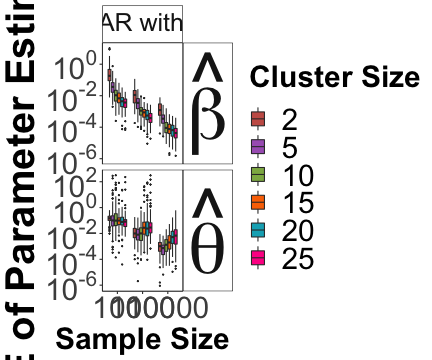

RObject{VecSxp}


In [10]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-6]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]
# msedfR[parameters == "rho",y_min := 10^-9]
# msedfR[parameters == "rho",y_max := 10^-2]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta)))))
msedfR$robust = factor(msedfR$robust, levels = c('Bernoulli AR with LogitLink'),
    labels = c(expression(paste("Bernoulli AR with LogitLink")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))



#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [11]:
R"""
ggsave('updated_msefacetplot_bernoulli_AR_uni2_rho_sigma2_0.5.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_bernoulli_AR_uni2_rho_sigma2_0.5.png"
